In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,
    LSTM, concatenate, BatchNormalization, Conv2D, MaxPooling2D, Reshape
)
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import plot_model

In [31]:

eeg_data = np.load(r'C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\data\processed\eeg_data_aligned.npy')          # Shape: (396, 500, 66)
audio_data = np.load(r'C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\data\processed\audio_data_cleaned.npy')      # Shape: (396, 100, 40)
labels = np.load(r'C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\data\processed\labels_cleaned.npy')    

In [32]:
# One-hot encode labels
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes)

In [33]:
# EEG branch
eeg_input = Input(shape=(500, 66), name='eeg_input')
x = Conv1D(64, kernel_size=5, activation='relu')(eeg_input)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=5, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = LSTM(64)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
eeg_out = x


In [34]:
# Audio branch
audio_input = Input(shape=(100, 40), name='audio_input')  # (timesteps, mfcc features)
reshaped = Reshape((100, 40, 1))(audio_input)  # Add channel dim

In [35]:
y = Conv2D(32, kernel_size=(3, 3), activation='relu')(reshaped)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Flatten()(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.5)(y)
audio_out = y

In [36]:
combined = concatenate([eeg_out, audio_out])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation='softmax')(z)

In [37]:
# Model
model = Model(inputs=[eeg_input, audio_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Save the model checkpoint
os.makedirs('saved_model', exist_ok=True)

In [39]:
checkpoint = ModelCheckpoint(
    r'C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\saved_model\multimodal_cnn_lstm.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [40]:
# Train the model
history = model.fit(
    [eeg_data, audio_data],
    labels,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3352 - loss: 28.2048
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\saved_model\multimodal_cnn_lstm.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.3432 - loss: 27.8932 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6225 - loss: 3.8257
Epoch 2: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.6217 - loss: 3.7426 - val_accuracy: 0.0000e+00 - val_loss: 1.2168
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6967 - loss: 0.9142
Epoch 3: val_accuracy did not improve from 1.00000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.7013 - loss: 0.9051 - val_accuracy: 0.1750 - val_loss: 1.2455
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8253 - loss: 0.5943
Epoch 4: val_accuracy did not 

In [41]:
predictions = model.predict([eeg_data, audio_data])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


In [42]:
cm = confusion_matrix(true_labels, predicted_labels)

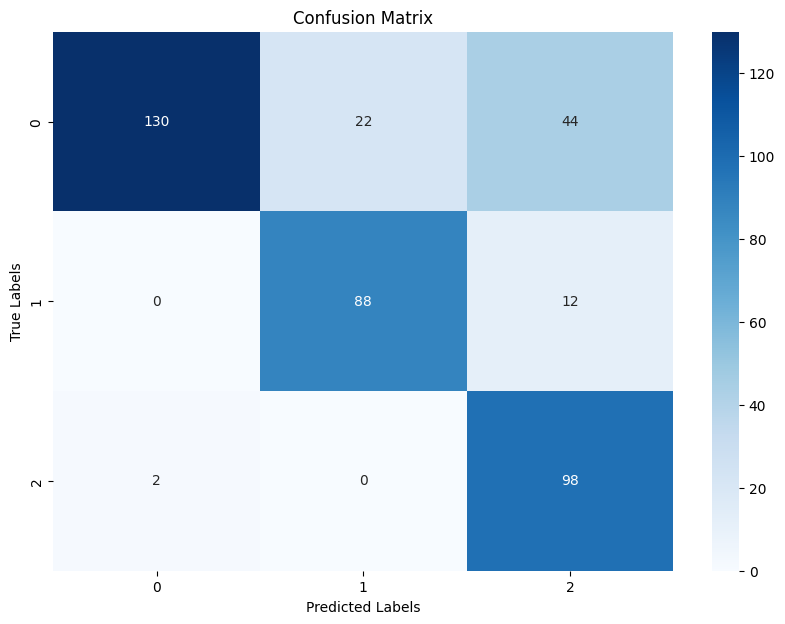

In [43]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
best_model = tf.keras.models.load_model(r'C:\Users\RAJ MOHNANI\OneDrive\Desktop\depression-prediction\saved_model\multimodal_cnn_lstm.keras')


In [28]:
# Evaluate the best model
eval_result = best_model.evaluate([eeg_data, audio_data], labels)
print(f"Test Loss: {eval_result[0]}")
print(f"Test Accuracy: {eval_result[1]}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9638 - loss: 0.1218
Test Loss: 0.2924351096153259
Test Accuracy: 0.9116161465644836


In [35]:
!pip install pydot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
# Train the model and ensure history is returned
history = model.fit(
    [eeg_data, audio_data],
    labels,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint]
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9799 - loss: 0.0665
Epoch 1: val_accuracy did not improve from 0.68750
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9791 - loss: 0.0683 - val_accuracy: 0.4500 - val_loss: 6.3588
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9796 - loss: 0.0660
Epoch 2: val_accuracy did not improve from 0.68750
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9795 - loss: 0.0662 - val_accuracy: 0.4500 - val_loss: 6.2005
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9766 - loss: 0.0558
Epoch 3: val_accuracy did not improve from 0.68750
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9770 - loss: 0.0568 - val_accuracy: 0.4500 - val_loss: 6.2366
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9796 - loss: 0.1247
Epoch 4: val_accuracy did not improve from 0.68750
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9791 - loss: 0.1244 - val_accuracy: 0.4500 - v

In [44]:
import matplotlib.pyplot as plt

# Check the available keys in history to confirm the correct ones for accuracy and loss
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [45]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

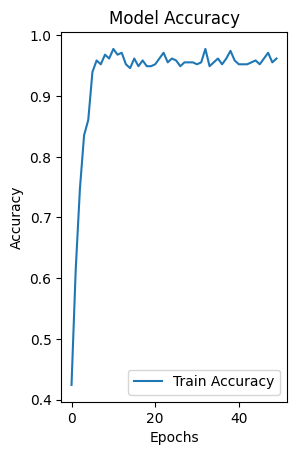

In [46]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

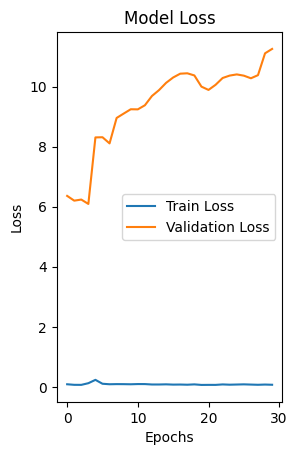

In [46]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()